# Google Playstore Rating

# 1. Data pre-processing

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

C:\Users\Fang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Import dataset and check length

In [2]:
raw=pd.read_csv("googleplaystore.csv")
review=pd.read_csv("googleplaystore_user_reviews.csv")
len(raw), len(review)

(10841, 64295)

Take a quick look at raw data

In [3]:
raw.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
review.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


Drop Duplicates

In [5]:
df=raw.drop_duplicates()
review=review.dropna().drop_duplicates()
len(df), len(review)

(10358, 29692)

Delete rows which ratings are NAN. 
Note that for all reviews that contain NAN, ratings also contain NAN.
This means after this step, in df reviews column, NAN is also removed. 

In [6]:
df = df[np.isfinite(raw['Rating'])]
len(df)

C:\Users\Fang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


8893

Check highest and lowest ratings for any outliers

In [7]:
df.nlargest(10, 'Rating')

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN
329,Hojiboy Tojiboyev Life Hacks,COMICS,5.0,15,37M,"1,000+",Free,0,Everyone,Comics,"June 26, 2018",2.0,4.0.3 and up
612,American Girls Mobile Numbers,DATING,5.0,5,4.4M,"1,000+",Free,0,Mature 17+,Dating,"July 17, 2018",3.0,4.0.3 and up
615,Awake Dating,DATING,5.0,2,70M,100+,Free,0,Mature 17+,Dating,"July 24, 2018",2.2.9,4.4 and up
633,Spine- The dating app,DATING,5.0,5,9.3M,500+,Free,0,Teen,Dating,"July 14, 2018",4.0,4.0.3 and up
636,Girls Live Talk - Free Text and Video Chat,DATING,5.0,6,5.0M,100+,Free,0,Mature 17+,Dating,"August 1, 2018",8.2,4.0.3 and up
640,Online Girls Chat Group,DATING,5.0,5,5.0M,100+,Free,0,Mature 17+,Dating,"August 2, 2018",8.2,4.0.3 and up
654,Speeding Joyride & Car Meet App,DATING,5.0,3,25M,100+,Free,0,Mature 17+,Dating,"July 20, 2018",1.2.9,4.1 and up
1028,SUMMER SONIC app,EVENTS,5.0,4,61M,500+,Free,0,Everyone,Events,"July 24, 2018",1.0,4.4 and up
1030,Prosperity,EVENTS,5.0,16,2.3M,100+,Free,0,Everyone,Events,"July 9, 2018",1.14,2.0 and up


In [8]:
df.nsmallest(10, 'Rating')

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
625,House party - live chat,DATING,1.0,1,9.2M,10+,Free,0,Mature 17+,Dating,"July 31, 2018",3.52,4.0.3 and up
4127,Speech Therapy: F,FAMILY,1.0,1,16M,10+,Paid,$2.99,Everyone,Education,"October 7, 2016",1.0,2.3.3 and up
5151,Clarksburg AH,MEDICAL,1.0,1,28M,50+,Free,0,Everyone,Medical,"May 1, 2017",300000.0.81,4.0.3 and up
5978,Truck Driving Test Class 3 BC,FAMILY,1.0,1,2.0M,50+,Paid,$1.49,Everyone,Education,"April 9, 2012",1.0,2.1 and up
6319,BJ Bridge Standard American 2018,GAME,1.0,1,4.9M,"1,000+",Free,0,Everyone,Card,"May 21, 2018",6.2-sayc,4.0 and up
6490,MbH BM,MEDICAL,1.0,1,2.3M,100+,Free,0,Everyone,Medical,"December 14, 2016",1.1.3,4.3 and up
7144,CB Mobile Biz,FINANCE,1.0,3,8.4M,500+,Free,0,Everyone,Finance,"February 22, 2016",4.4.1255,4.0 and up
7383,Thistletown CI,PRODUCTIVITY,1.0,1,6.6M,100+,Free,0,Everyone,Productivity,"March 15, 2018",41.9,4.1 and up
7427,CJ DVD Rentals,COMMUNICATION,1.0,5,13M,100+,Free,0,Everyone,Communication,"October 6, 2017",1.0,4.1 and up
7806,CR Magazine,BUSINESS,1.0,1,7.8M,100+,Free,0,Everyone,Business,"July 23, 2014",2.4.2,2.3.3 and up


Drop outliers and check again

In [9]:
df=df[df.Rating!=19]
df.nlargest(10, 'Rating')

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
329,Hojiboy Tojiboyev Life Hacks,COMICS,5.0,15,37M,"1,000+",Free,0,Everyone,Comics,"June 26, 2018",2.0,4.0.3 and up
612,American Girls Mobile Numbers,DATING,5.0,5,4.4M,"1,000+",Free,0,Mature 17+,Dating,"July 17, 2018",3.0,4.0.3 and up
615,Awake Dating,DATING,5.0,2,70M,100+,Free,0,Mature 17+,Dating,"July 24, 2018",2.2.9,4.4 and up
633,Spine- The dating app,DATING,5.0,5,9.3M,500+,Free,0,Teen,Dating,"July 14, 2018",4.0,4.0.3 and up
636,Girls Live Talk - Free Text and Video Chat,DATING,5.0,6,5.0M,100+,Free,0,Mature 17+,Dating,"August 1, 2018",8.2,4.0.3 and up
640,Online Girls Chat Group,DATING,5.0,5,5.0M,100+,Free,0,Mature 17+,Dating,"August 2, 2018",8.2,4.0.3 and up
654,Speeding Joyride & Car Meet App,DATING,5.0,3,25M,100+,Free,0,Mature 17+,Dating,"July 20, 2018",1.2.9,4.1 and up
1028,SUMMER SONIC app,EVENTS,5.0,4,61M,500+,Free,0,Everyone,Events,"July 24, 2018",1.0,4.4 and up
1030,Prosperity,EVENTS,5.0,16,2.3M,100+,Free,0,Everyone,Events,"July 9, 2018",1.14,2.0 and up
1038,Mindvalley U Tallinn 2018,EVENTS,5.0,1,21M,100+,Free,0,Everyone,Events,"July 3, 2018",1.0.5,4.4 and up


Check data types in each column and we can see that other than column "Rating", the rest are non-numeric

In [10]:
df.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

Replace all plus signs in column "Installs"; Get rid of "M", "," in column "Size"; Get rid of "$" in column "Price". Note that for "Varies with device" in "Size" column, we are replacing it with string '0' for computation sake, it will be converted to NA later.

In [11]:
df['Installs'] = df['Installs'].str.replace('+','')
df['Installs'] = df['Installs'].str.replace(',','')
df['Price'] = df['Price'].str.replace('$','')
df['Size'] = df['Size'].str.replace(',','')
df['Size'] = df['Size'].str.replace('Varies with device','0')
df['Size'] = df['Size'].map(lambda x: x.rstrip('M'))
df.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19,10000,Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14,500000,Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25,50000000,Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6,50000,Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19,50000,Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up
7,Infinite Painter,ART_AND_DESIGN,4.1,36815,29,1000000,Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33,1000000,Free,0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121,3.1,10000,Free,0,Everyone,Art & Design;Creativity,"July 3, 2018",2.8,4.0.3 and up


Reviews are converted to numeric values

In [12]:
df['Reviews']=pd.to_numeric(df['Reviews'])
df.nsmallest(10, 'Reviews')
df.nlargest(10,'Reviews')

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2544,Facebook,SOCIAL,4.1,78158306,0,1000000000,Free,0,Teen,Social,"August 3, 2018",Varies with device,Varies with device
3943,Facebook,SOCIAL,4.1,78128208,0,1000000000,Free,0,Teen,Social,"August 3, 2018",Varies with device,Varies with device
336,WhatsApp Messenger,COMMUNICATION,4.4,69119316,0,1000000000,Free,0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device
3904,WhatsApp Messenger,COMMUNICATION,4.4,69109672,0,1000000000,Free,0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device
2604,Instagram,SOCIAL,4.5,66577446,0,1000000000,Free,0,Teen,Social,"July 31, 2018",Varies with device,Varies with device
2545,Instagram,SOCIAL,4.5,66577313,0,1000000000,Free,0,Teen,Social,"July 31, 2018",Varies with device,Varies with device
3909,Instagram,SOCIAL,4.5,66509917,0,1000000000,Free,0,Teen,Social,"July 31, 2018",Varies with device,Varies with device
382,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56646578,0,1000000000,Free,0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
335,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56642847,0,1000000000,Free,0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
1879,Clash of Clans,GAME,4.6,44893888,98,100000000,Free,0,Everyone 10+,Strategy,"July 15, 2018",10.322.16,4.1 and up


Installs are converted to numeric values

In [13]:
df['Installs']=pd.to_numeric(df['Installs'])
df.nsmallest(10, 'Installs')
df.nlargest(10,'Installs')

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
152,Google Play Books,BOOKS_AND_REFERENCE,3.9,1433233,0,1000000000,Free,0,Teen,Books & Reference,"August 3, 2018",Varies with device,Varies with device
335,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56642847,0,1000000000,Free,0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
336,WhatsApp Messenger,COMMUNICATION,4.4,69119316,0,1000000000,Free,0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device
338,Google Chrome: Fast & Secure,COMMUNICATION,4.3,9642995,0,1000000000,Free,0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
340,Gmail,COMMUNICATION,4.3,4604324,0,1000000000,Free,0,Everyone,Communication,"August 2, 2018",Varies with device,Varies with device
341,Hangouts,COMMUNICATION,4.0,3419249,0,1000000000,Free,0,Everyone,Communication,"July 21, 2018",Varies with device,Varies with device
382,Messenger – Text and Video Chat for Free,COMMUNICATION,4.0,56646578,0,1000000000,Free,0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device
386,Hangouts,COMMUNICATION,4.0,3419433,0,1000000000,Free,0,Everyone,Communication,"July 21, 2018",Varies with device,Varies with device
391,Skype - free IM & video calls,COMMUNICATION,4.1,10484169,0,1000000000,Free,0,Everyone,Communication,"August 3, 2018",Varies with device,Varies with device
411,Google Chrome: Fast & Secure,COMMUNICATION,4.3,9643041,0,1000000000,Free,0,Everyone,Communication,"August 1, 2018",Varies with device,Varies with device


Price is converted to numeric values

In [14]:
df['Price']=pd.to_numeric(df['Price'])
df.nsmallest(10, 'Price')
df.nlargest(10,'Price')

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
4367,I'm Rich - Trump Edition,LIFESTYLE,3.6,275,7.3,10000,Paid,400.00,Everyone,Lifestyle,"May 3, 2018",1.0.1,4.1 and up
4197,most expensive app (H),FAMILY,4.3,6,1.5,100,Paid,399.99,Everyone,Entertainment,"July 16, 2018",1.0,7.0 and up
4362,💎 I'm rich,LIFESTYLE,3.8,718,26,10000,Paid,399.99,Everyone,Lifestyle,"March 11, 2018",1.0.0,4.4 and up
5351,I am rich,LIFESTYLE,3.8,3547,1.8,100000,Paid,399.99,Everyone,Lifestyle,"January 12, 2018",2.0,4.0.3 and up
5354,I am Rich Plus,FAMILY,4.0,856,8.7,10000,Paid,399.99,Everyone,Entertainment,"May 19, 2018",3.0,4.4 and up
5356,I Am Rich Premium,FINANCE,4.1,1867,4.7,50000,Paid,399.99,Everyone,Finance,"November 12, 2017",1.6,4.0 and up
5358,I am Rich!,FINANCE,3.8,93,22,1000,Paid,399.99,Everyone,Finance,"December 11, 2017",1.0,4.1 and up
5359,I am rich(premium),FINANCE,3.5,472,965k,5000,Paid,399.99,Everyone,Finance,"May 1, 2017",3.4,4.4 and up
5362,I Am Rich Pro,FAMILY,4.4,201,2.7,5000,Paid,399.99,Everyone,Entertainment,"May 30, 2017",1.54,1.6 and up
5364,I am rich (Most expensive app),FINANCE,4.1,129,2.7,1000,Paid,399.99,Teen,Finance,"December 6, 2017",2,4.0.3 and up


Converting all strings in Size column that contains k, which means the unit is kB, to MB by dividing 1000

In [15]:
a=df['Size'][df['Size'].str.contains('k', regex=False)].map(lambda x: x.rstrip('k')).astype(float)/1000
df['Size'].update(a)

Convert Size column to numeric values

In [16]:
df['Size']=pd.to_numeric(df['Size'], errors='coerce')
df.nsmallest(10, 'Size')
df.nlargest(10,'Size')

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
1080,Post Bank,FINANCE,4.5,60449,100.0,1000000,Free,0.00,Everyone,Finance,"July 23, 2018",2.9.12,4.0 and up
1565,Talking Babsy Baby: Baby Games,LIFESTYLE,4.0,140995,100.0,10000000,Free,0.00,Everyone,Lifestyle;Pretend Play,"July 16, 2018",9.0,4.0 and up
1758,Hungry Shark Evolution,GAME,4.5,6074334,100.0,100000000,Free,0.00,Teen,Arcade,"July 25, 2018",6.0.0,4.1 and up
1793,Mini Golf King - Multiplayer Game,GAME,4.5,531458,100.0,5000000,Free,0.00,Everyone,Sports,"July 20, 2018",3.04.1,4.0.3 and up
1988,Hungry Shark Evolution,GAME,4.5,6074627,100.0,100000000,Free,0.00,Teen,Arcade,"July 25, 2018",6.0.0,4.1 and up
2299,Navi Radiography Pro,MEDICAL,4.7,11,100.0,500,Paid,15.99,Everyone,Medical,"January 14, 2018",1.2.0,4.0.3 and up
3973,Hungry Shark Evolution,GAME,4.5,6071542,100.0,100000000,Free,0.00,Teen,Arcade,"July 25, 2018",6.0.0,4.1 and up
4690,Vi Trainer,HEALTH_AND_FITNESS,3.6,124,100.0,5000,Free,0.00,Everyone,Health & Fitness,"August 2, 2018",2.0.0.11,5.0 and up
5427,Ultimate Tennis,SPORTS,4.3,183004,100.0,10000000,Free,0.00,Everyone,Sports,"July 19, 2018",2.29.3118,4.0.3 and up
5530,The Walking Dead: Our World,GAME,4.0,22435,100.0,1000000,Free,0.00,Teen,Action,"August 1, 2018",1.1.0.3,5.0 and up


Replace zero values of Size with nan first

In [17]:
df['Size']=df['Size'].replace(0, np.nan)
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Fill "Varies with device" with mean of size in each category for Size column

In [18]:
df['Size'].fillna(df.groupby('Category')['Size'].transform('mean'),inplace=True)
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Fill "Varies with device" with mean of size in each category for Android Version column

In [19]:
ver_mode = df.groupby('Category')['Android Ver'].apply(lambda x: x.mode())
df = df.reset_index(drop = True)
for i in range(len(df)): 
    if pd.isnull(df.loc[i, 'Android Ver']): 
        df.loc[i, 'Category'] = ver_mode[df.loc[i, 'Category']][0]

In [20]:
df['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION',
       '4.0.3 and up'], dtype=object)

Remove miscoding in Category

In [21]:
len(df)

8892

In [22]:
df = df[df.Category != '4.0.3 and up']
len(df)

8890

Drop current version and last updated columns which are not useful for our prediction and analysis 

In [23]:
df=df.drop(['Current Ver', 'Last Updated'], axis=1)
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,10000,Free,0.0,Everyone,Art & Design,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,5000000,Free,0.0,Everyone,Art & Design,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,50000000,Free,0.0,Teen,Art & Design,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,4.4 and up


# 2. Explanatory Data Analysis

Plot the heatmap of all numerical variables to get an overview of relationships between them

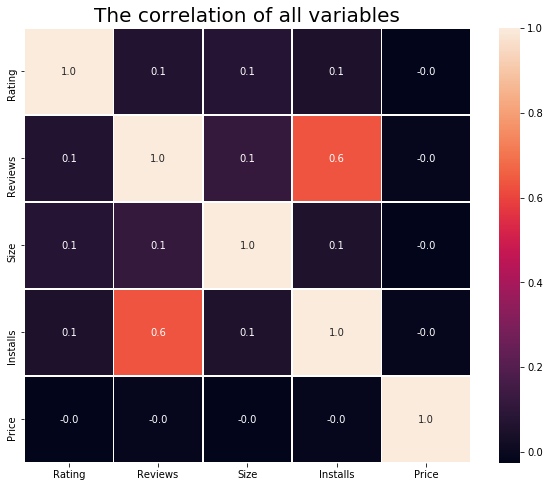

In [24]:
f,ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title("The correlation of all variables",size=20)           
plt.show()

Basically rating would be influenced by reviews, size and installs and obviously reviews are correlated with installations.

## Rating

Our main goal for Explanatory Data Analysis is to see the relationship between other variables and rating. 

In [25]:
df['Rating'].describe()

count    8890.000000
mean        4.187818
std         0.522420
min         1.000000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

Plot the countplot of Rating to see the range of rating

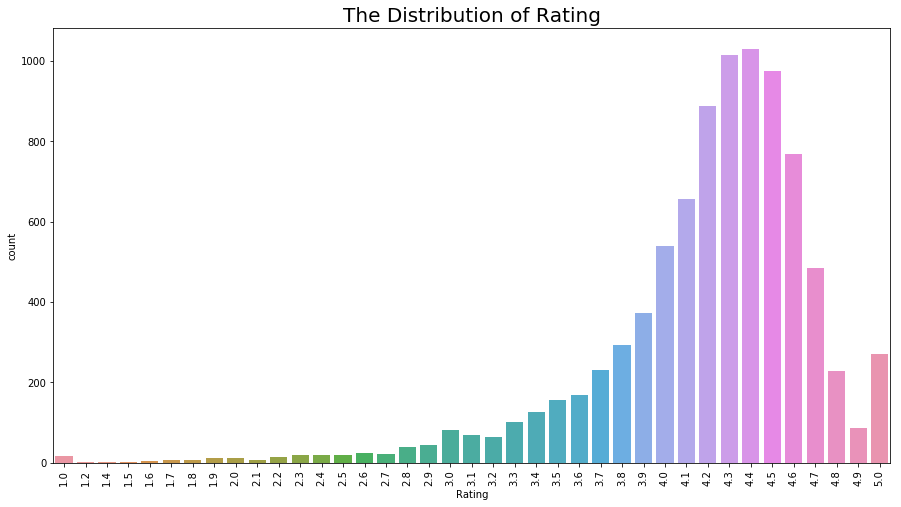

In [26]:
plt.subplots(figsize = (15,8))
plt.xticks(rotation = 90)
plt.title("The Distribution of Rating", size=20)
sns.countplot('Rating', data = df)
plt.show()

Based on the bellcurve we got, most applications got rated in the range of 4.0 to 4.7

## Category

Plot the distribution of number of applications in each category

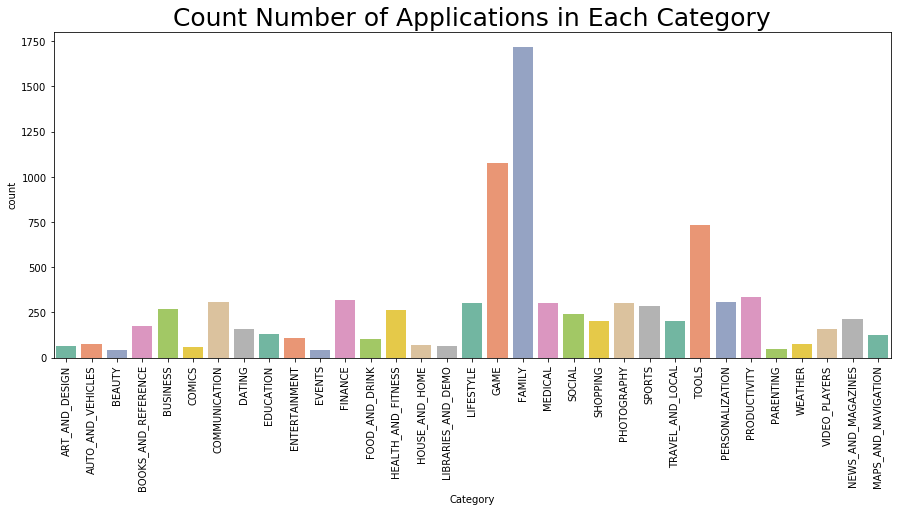

In [27]:
plt.figure(figsize=(15,6))
plt.title('Count Number of Applications in Each Category',size = 25)
category = sns.countplot(x=df['Category'], palette="Set2")
category.set_xticklabels(category.get_xticklabels(),rotation=90)
plt.show(category)

Catergory FAMILY has most applications, and category GAME and TOOLS also have a lot of applications.

Plot the ratings for each category

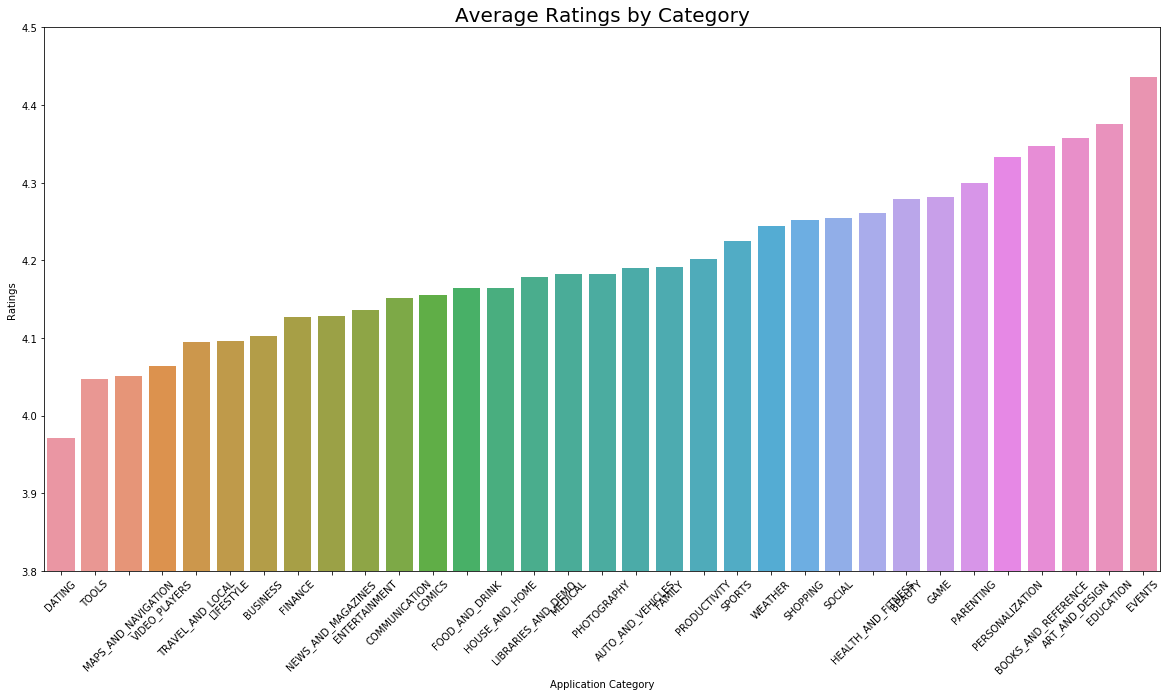

In [28]:
result = df.groupby(["Category"])['Rating'].aggregate(np.mean).reset_index().sort_values('Rating')

plt.figure(figsize=(20,10))
sns.barplot(x=df.Category, y=df.Rating,ci=None,order=result['Category'])

plt.xticks(rotation = 45)
plt.ylim(3.8,4.5)
plt.xlabel('Application Category')
plt.ylabel('Ratings')
plt.title('Average Ratings by Category',size=20)
plt.show()

Based on the barplot, the category EVENTS has highest rating and category DATING has lowest rating.

## Reviews

Plot the distibution of reviews

C:\Users\Fang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Distribution of Review')

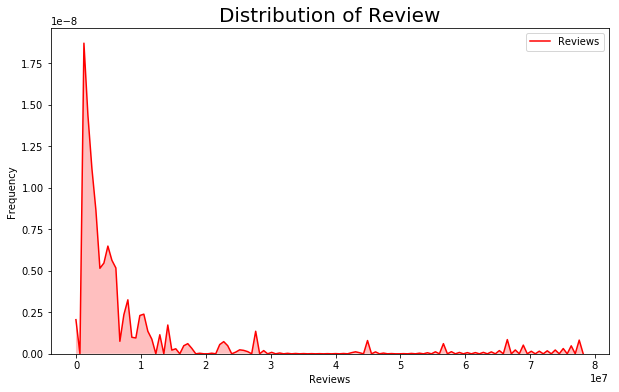

In [29]:
plt.figure(figsize=(10,6))
rewviews = sns.kdeplot(df.Reviews, color="Red", shade = True)
rewviews.set_xlabel("Reviews")
rewviews.set_ylabel("Frequency")
plt.title('Distribution of Review',size = 20)

Most of applications in the store have less than 1M in reviews. 

Plot the regplot of reviews VS ratings

C:\Users\Fang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Rating VS Reveiws')

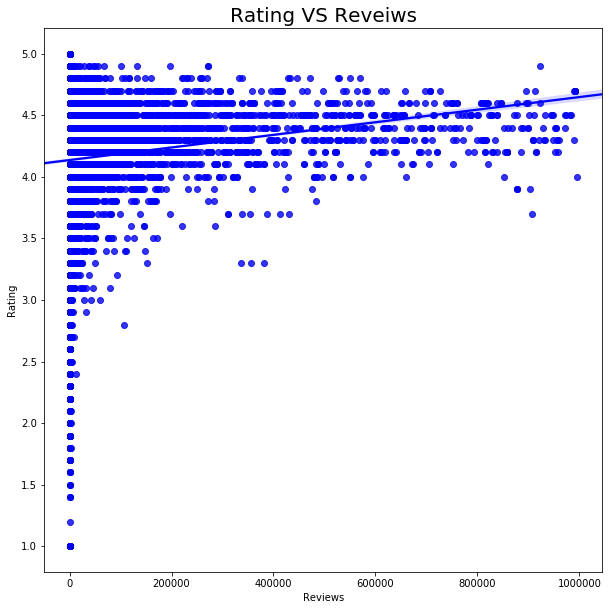

In [30]:
plt.figure(figsize = (10,10))
sns.regplot(x="Reviews", y="Rating", color = 'Blue',data=df[df['Reviews']<1000000]);
plt.title('Rating VS Reveiws',size = 20)

The applications with more reviews get higher ratings.

Plot the number of reviews for each category

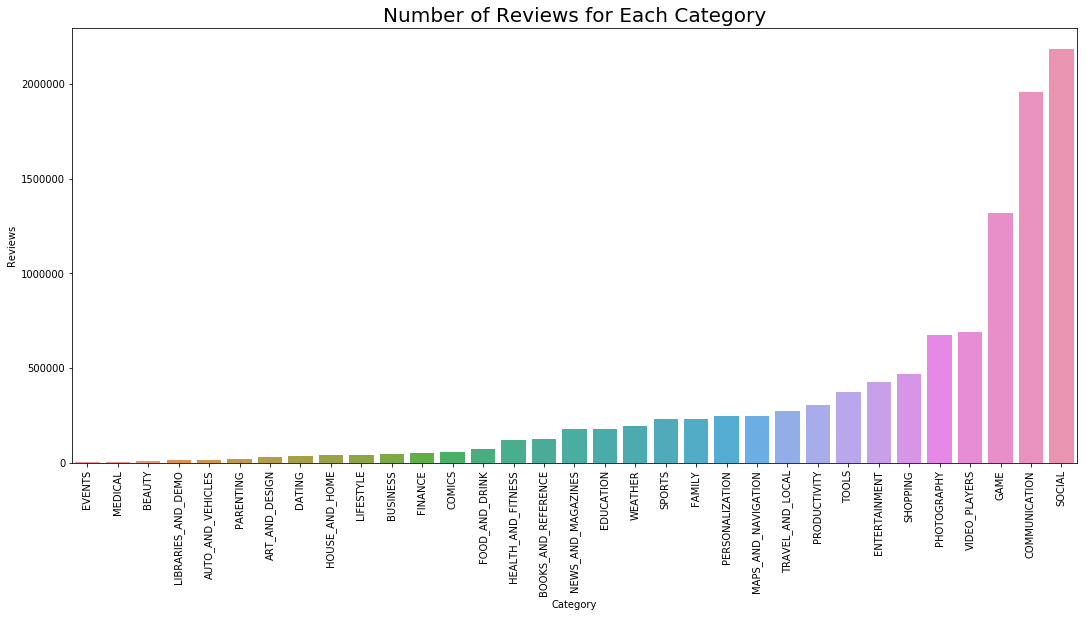

In [31]:
result1 = df.groupby(["Category"])['Reviews'].aggregate(np.mean).reset_index().sort_values('Reviews')

plt.subplots(figsize = (18,8))
plt.xticks(rotation = 90)
sns.barplot('Category','Reviews', ci=None, data = df, order=result1['Category'])
plt.title('Number of Reviews for Each Category',size=20)
plt.show()

Based on the barplot, the category SOCIAL received most reviews and category EVENTS have least reviews.

Plot the average installs for each category

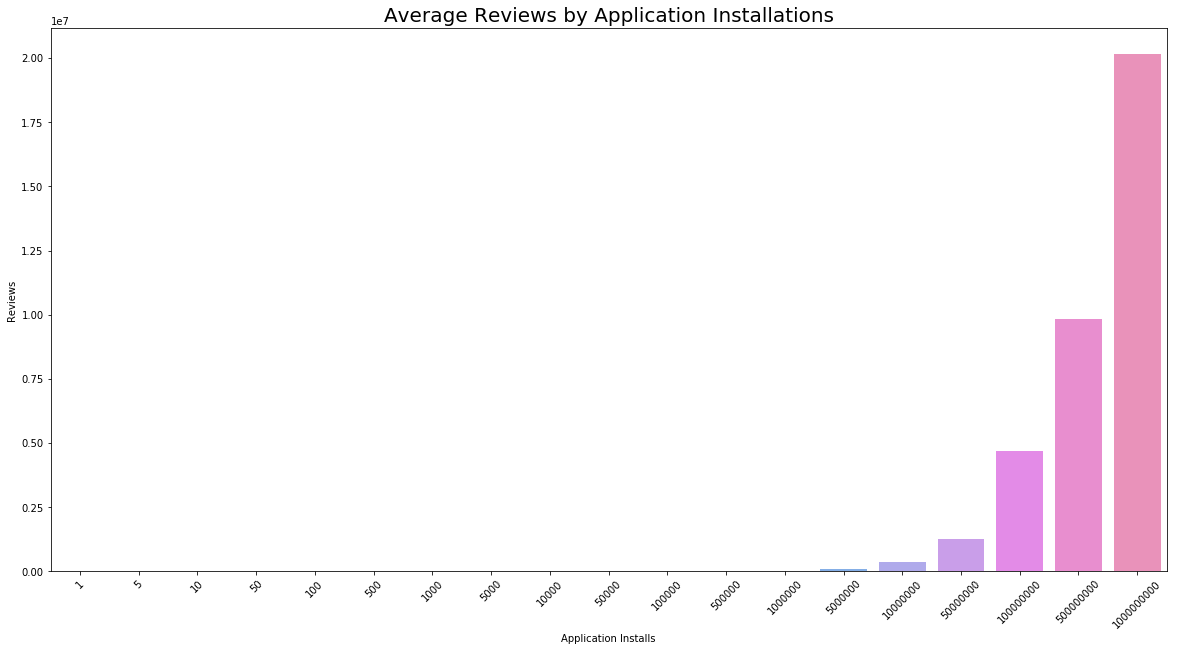

In [32]:
result3 = df.groupby(["Installs"])['Reviews'].aggregate(np.mean).reset_index().sort_values('Reviews')

plt.figure(figsize=(20,10))
sns.barplot(x=df.Installs, y=df.Reviews,ci=None,order=result3['Installs'])

plt.xticks(rotation = 45)
plt.xlabel('Application Installs')
plt.ylabel('Reviews')
plt.title('Average Reviews by Application Installations',size=20)
plt.show()

Based on the barplot, the most installed application got lots of reviews.

## Size

Plot the jointplot of Rating VS Size

C:\Users\Fang\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Fang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 720x720 with 0 Axes>

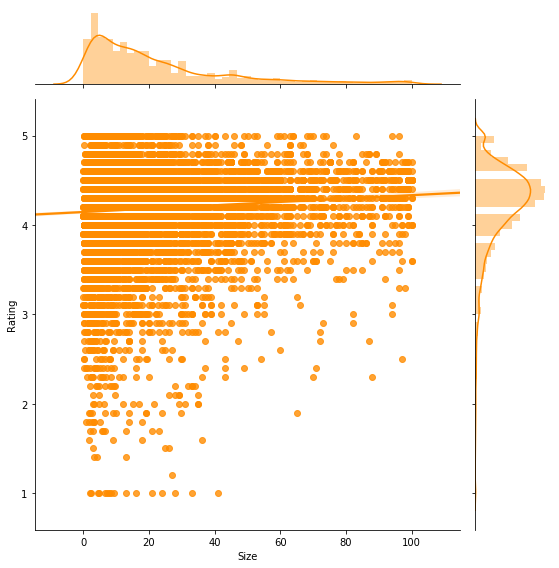

In [33]:
plt.figure(figsize = (10,10))
size = sns.jointplot(x="Size", y="Rating",color = 'darkorange', data=df, size = 8, kind="reg")

Based on the distribution and regression line, we conclude that there is the relationship between “Size” vs “Rating” is not very obvious, but basically larger size applications will get a little bit higher rating.

Plot the average size for each category

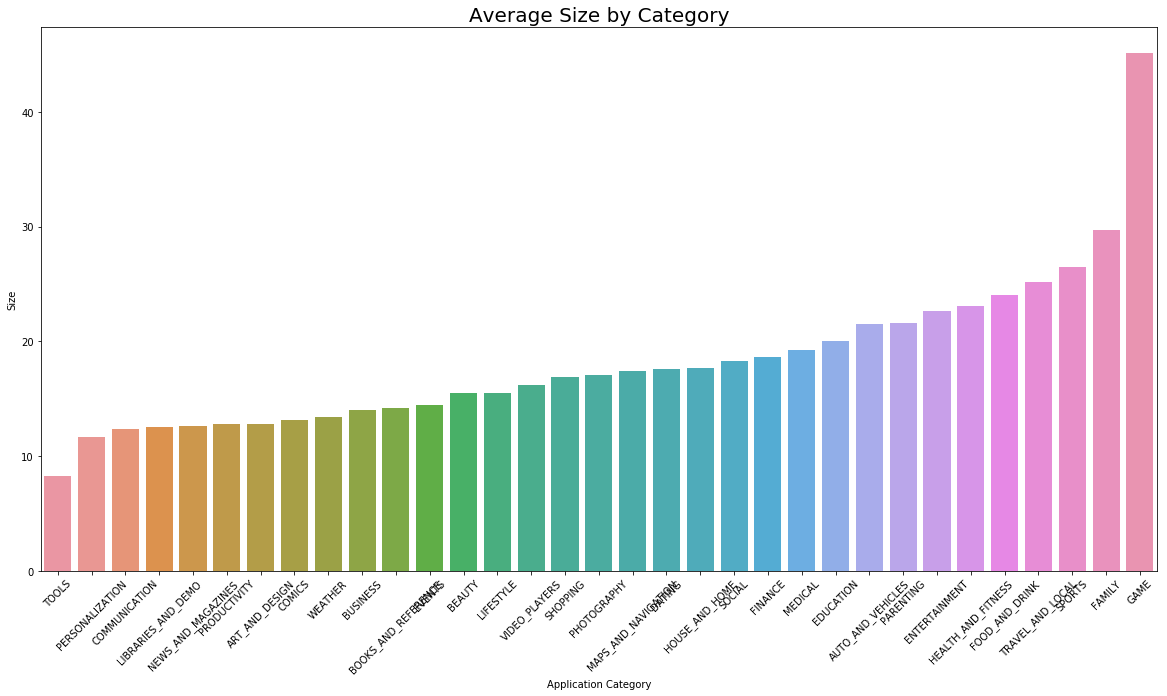

In [34]:
result2 = df.groupby(["Category"])['Size'].aggregate(np.mean).reset_index().sort_values('Size')

plt.figure(figsize=(20,10))
sns.barplot(x=df.Category, y=df.Size,ci=None,order=result2['Category'])

plt.xticks(rotation = 45)
plt.xlabel('Application Category')
plt.ylabel('Size')
plt.title('Average Size by Category',size=20)
plt.show()

Based on the barplot, the category GAME has largest size and category TOOLS has smallest size.

## Installs

Plot the regplot of Installs VS Ratings

C:\Users\Fang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Rating VS Installs')

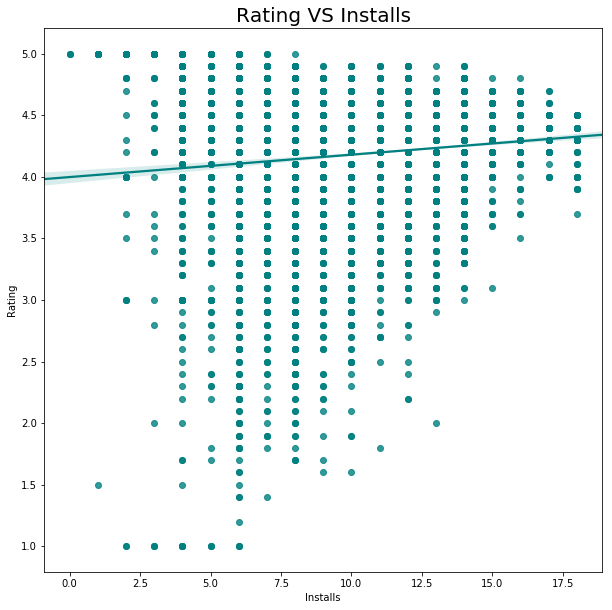

In [35]:
Sorted_value = sorted(list(df['Installs'].unique()))
df['Installs'].replace(Sorted_value,range(0,len(Sorted_value),1), inplace = True )

plt.figure(figsize = (10,10))
sns.regplot(x="Installs", y="Rating", color = 'teal',data=df);
plt.title('Rating VS Installs',size = 20)

Based on the regplot we can see that Rating is increasing when the number of installs increases.

Plot the average installs for each category

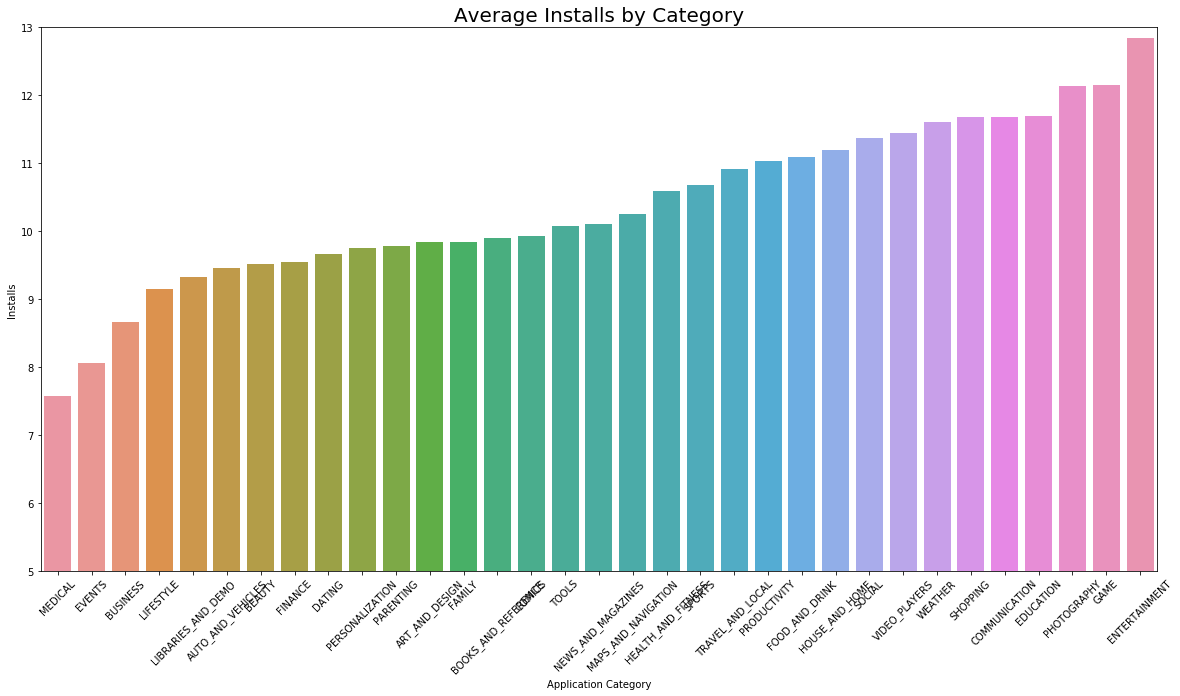

In [36]:
result3 = df.groupby(["Category"])['Installs'].aggregate(np.mean).reset_index().sort_values('Installs')

plt.figure(figsize=(20,10))
sns.barplot(x=df.Category, y=df.Installs,ci=None,order=result3['Category'])

plt.xticks(rotation = 45)
plt.ylim(5,13)
plt.xlabel('Application Category')
plt.ylabel('Installs')
plt.title('Average Installs by Category',size=20)
plt.show()

Based on the barplot, the category COMMUNICATION has most installs and category MEDICAL has least installs.

## Type

Find percentage of free applications

In [37]:
totalapp_free_df = (df[df.Type == 'Free'].count().iloc[0] / df['App'].count() * 100).round(2)
totalapp_free_df

93.12

Find percentage of paid applications

In [38]:
totalapp_paid_df = (df[df.Type == 'Paid'].count().iloc[0] / df['App'].count() * 100).round(2)
totalapp_paid_df

6.88

Plot the pie chart of the percentage of free and paid applications

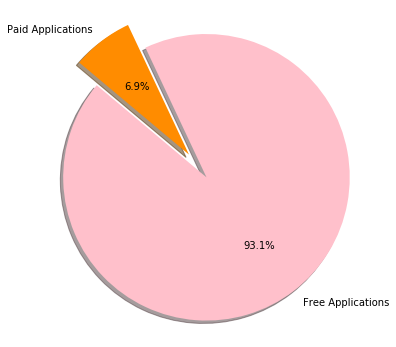

In [39]:
plt.figure(figsize=(6,6,))
labels = 'Free Applications', 'Paid Applications'
sizes = [93.11,6.89]
explode = (0.2,0)
colors = ['pink','darkorange']
plt.pie(sizes, explode=explode,labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

Basically most of applications are free.

Compare the average rating of free applications and paid applications

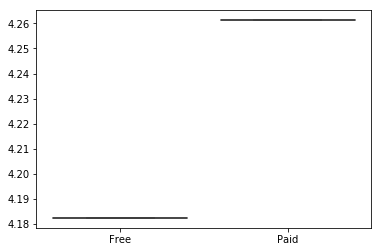

In [40]:
totalapp_free_df=df[df.Type=='Free'].Rating.mean()
totalapp_paid_df=df[df.Type!='Free'].Rating.mean()
sns.boxplot(x=['Free','Paid'],y=[totalapp_free_df,totalapp_paid_df])

We can see that paid applications have higher average rating than free applications.

Pairwise Plot of Numeric Features based on free applications and paid applications

C:\Users\Fang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


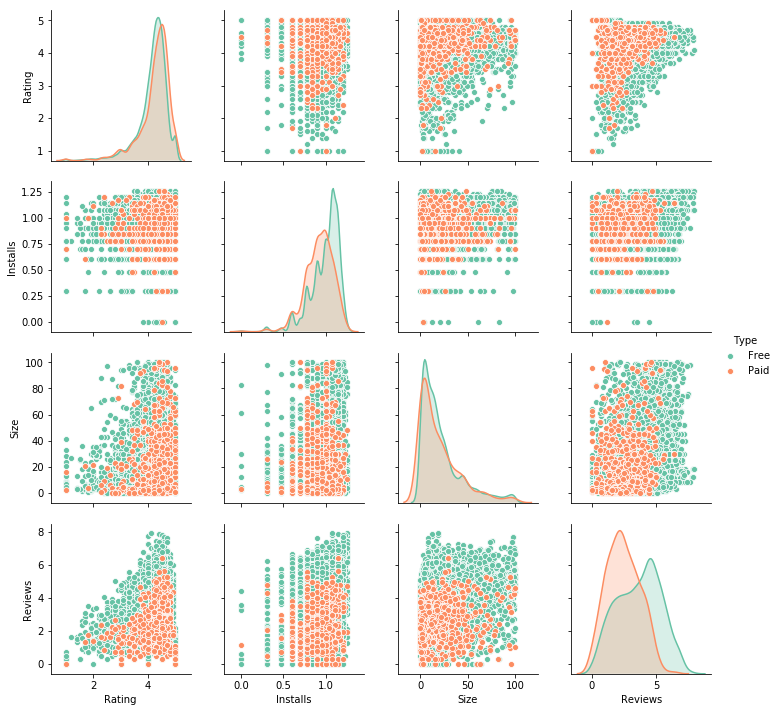

In [41]:
rating = df['Rating'].dropna()
size = df['Size'].dropna()
installs = df['Installs'][df.Installs!=0].dropna()
reviews = df['Reviews'][df.Reviews!=0].dropna()
type = df['Type'].dropna()
pairplot = sns.pairplot(pd.DataFrame(list(zip(rating, np.log10(installs), size, np.log10(reviews), type)),
                                     columns=['Rating', 'Installs', 'Size','Reviews', 'Type']), hue='Type', palette="Set2")

Based on the pairwise plots we conclude that free applications get higher ratings. Still, the overall distributions of ratings for free applications and paid applications respectively are highly similar. The same can be said for the overall distributions of sizes for free applications and paid applications. Meanwhile, although free applications have more installations then paid applications, paid applications received more reviews than free applications. 

## Price

Set our own PriceBand

In [42]:
df.loc[df['Price'] == 0, 'PriceBand'] = '0 Free'
df.loc[(df['Price'] > 0) & (df['Price'] <= 0.99), 'PriceBand'] = '1 Cheap'
df.loc[(df['Price'] > 0.99) & (df['Price'] <= 2.99), 'PriceBand']   = '2 Not Too Cheap'
df.loc[(df['Price'] > 2.99) & (df['Price'] <= 4.99), 'PriceBand']   = '3 Normal'
df.loc[(df['Price'] > 4.99) & (df['Price'] <= 14.99), 'PriceBand']   = '4 Not Too Expensive'
df.loc[(df['Price'] > 14.99) & (df['Price'] <= 29.99), 'PriceBand']   = '5 Expensive'
df.loc[(df['Price'] > 29.99), 'PriceBand']  = '6 Too Expensive'

In [43]:
df[['PriceBand', 'Rating']].groupby(['PriceBand'], as_index=False).mean()

,PriceBand,Rating
0,0 Free,4.182387
1,1 Cheap,4.298095
2,2 Not Too Cheap,4.293671
3,3 Normal,4.238816
4,4 Not Too Expensive,4.245000
5,5 Expensive,4.252632
6,6 Too Expensive,3.910526


Plot the boxplot of Price VS Rating based on PriceBand we set 

[]

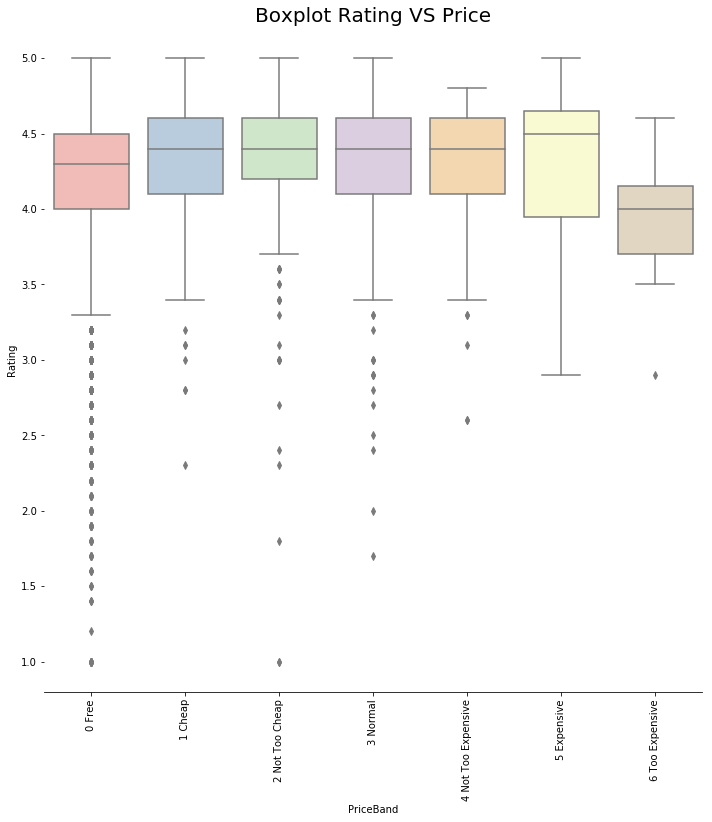

In [44]:
price = sns.catplot(x="PriceBand",y="Rating",data=df, kind="box", height = 10 ,palette = "Pastel1",
                    order=["0 Free", "1 Cheap","2 Not Too Cheap", "3 Normal", "4 Not Too Expensive", "5 Expensive", "6 Too Expensive"])
price.despine(left=True)
price.set_xticklabels(rotation=90)
price.set_ylabels("Rating")
plt.title('Boxplot Rating VS Price',size = 20)
plt.plot()

Based on the boxplot we get, if an application is very expensive, it might get low rating. 

## Content Rating

Plot the countplot of Content Rating

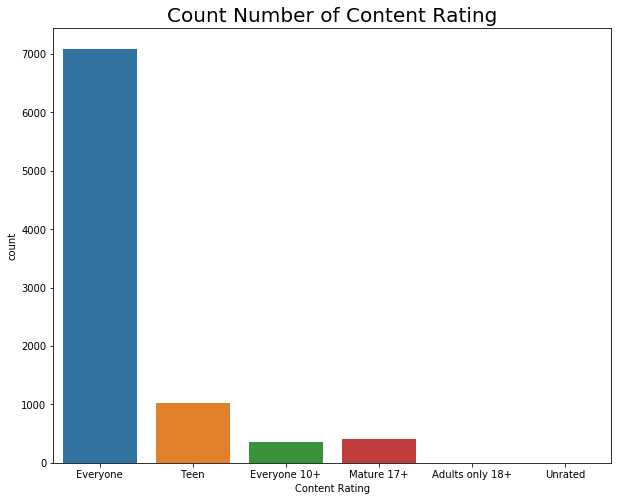

In [45]:
plt.figure(figsize = (10,8))
plt.title('Count Number of Content Rating',size=20)
sns.countplot(df['Content Rating'])
plt.show()

Basically most applications got ratings from Everyone. 

Set our own ContentRatingBand

In [46]:
df.loc[df['Content Rating'] == 'Everyone', 'ContentRatingBand'] = 'Everyone'
df.loc[(df['Content Rating'] == 'Teen'), 'ContentRatingBand'] = 'Teen'
df.loc[(df['Content Rating'] == 'Everyone 10+'), 'ContentRatingBand'] = 'Everyone 10+'
df.loc[(df['Content Rating'] == 'Mature 17+'), 'ContentRatingBand'] = 'Mature 17+'
df.loc[(df['Content Rating'] == 'Adults only 18+'), 'ContentRatingBand'] = 'Adults only 18+'
df.loc[(df['Content Rating'] == 'Unrated'), 'ContentRatingBand'] = 'Unrated'

In [47]:
df[['ContentRatingBand', 'Rating']].groupby(['ContentRatingBand'], as_index=False).mean()

,ContentRatingBand,Rating
0,Adults only 18+,4.300000
1,Everyone,4.180742
2,Everyone 10+,4.254167
3,Mature 17+,4.124331
4,Teen,4.238845
5,Unrated,4.100000


Plot the boxenplot of Rating VS Content Rating based on ContentRatingBand we set 

[]

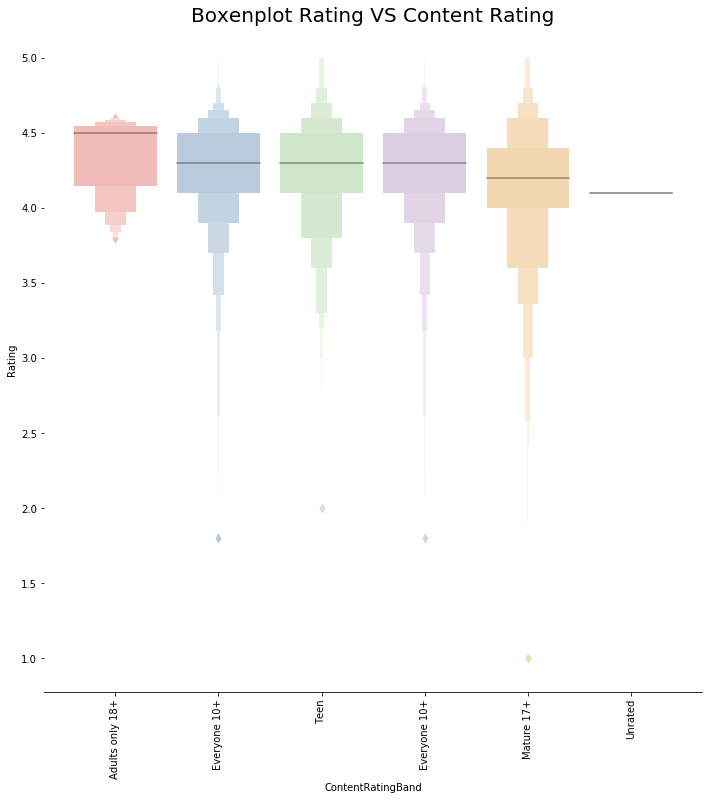

In [48]:
price = sns.catplot(x="ContentRatingBand",y="Rating",data=df, kind="boxen", height = 10 ,palette = "Pastel1",
                    order=["Adults only 18+", "Everyone 10+", "Teen", "Everyone 10+", "Mature 17+","Unrated"])
price.despine(left=True)
price.set_xticklabels(rotation=90)
price.set_ylabels("Rating")
plt.title('Boxenplot Rating VS Content Rating',size = 20)
plt.plot()

Based on the boxenplot we get, applications rated by adults only 18+ got highest rating.

Plot the pieplot for percentage of reviews for each content rating

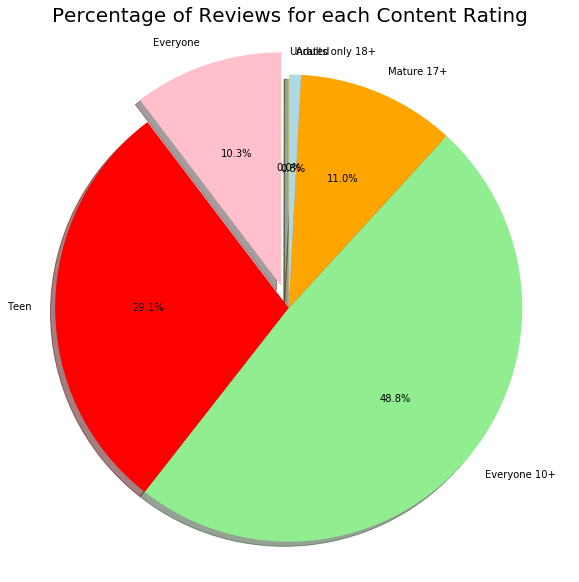

In [49]:
labels=df['Content Rating'].unique()
explode = (0.1, 0, 0, 0, 0,0)
size=list()
for content in labels:
    size.append(df[df['Content Rating']==content]['Reviews'].mean())
    
plt.figure(figsize=(10,10))
colors = ['pink','red','lightgreen','orange', 'lightblue','yellow']
plt.pie(size, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')
plt.title('Percentage of Reviews for each Content Rating',size = 20)
plt.show()

We can conclude from the pie plot that children and young people wrote more reviews.

## Genre

Check the ratings of each genre

In [50]:
df[['Genres', 'Rating']].groupby(['Genres'], as_index=False).mean().sort_values('Rating')

,Genres,Rating
75,Parenting;Brain Games,3.800000
76,Parenting;Education,3.866667
44,Educational,3.871875
61,Health & Fitness;Action & Adventure,3.900000
11,Art & Design;Pretend Play,3.900000
47,Educational;Creativity,3.960000
36,Dating,3.971698
67,Lifestyle;Pretend Play,4.000000
56,Entertainment;Pretend Play,4.000000
112,Video Players & Editors;Music & Video,4.000000


In [51]:
df[['Genres', 'Rating']].groupby(['Genres'], as_index=False).mean().describe()

,Rating
count,115.000000
mean,4.258858
std,0.182190
min,3.800000
25%,4.148914
50%,4.266667
75%,4.354464
max,4.800000


Based on the standard deviation we got, genre does not affect rating too much.

Plot the boxenplot of rating vs genres

Text(0.5,1,'Boxenplot of Rating VS Genres')

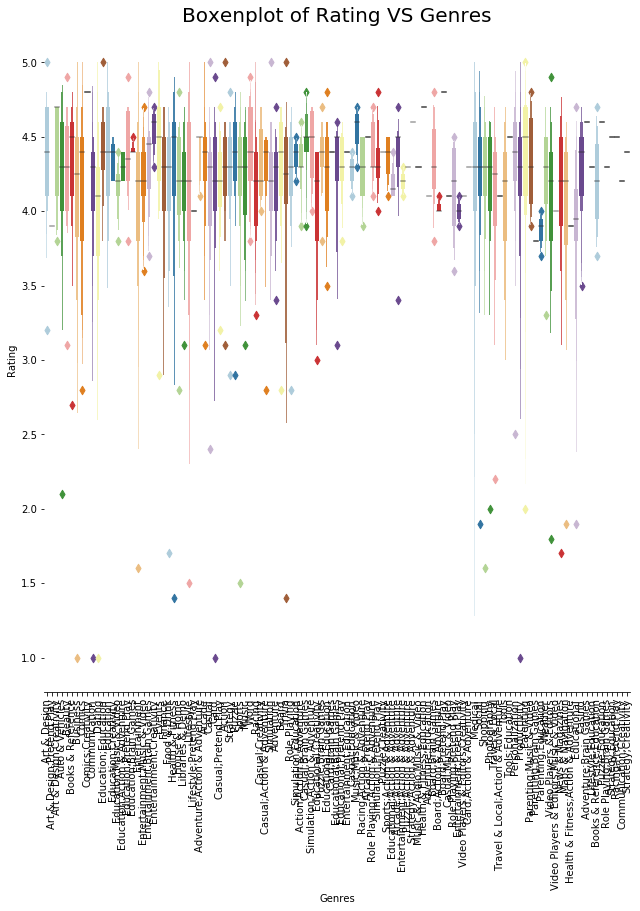

In [52]:
genre = sns.catplot(x="Genres",y="Rating",data=df, kind="boxen", height = 10 ,palette = "Paired")
genre.despine(left=True)
genre.set_xticklabels(rotation=90)
genre = genre.set_ylabels("Rating")
plt.title('Boxenplot of Rating VS Genres',size = 20)

From the boxenplot we cannot say that genres have strong relationship with ratings. 

But we can see that the genre of Comics;Creativity and Board;Pretend Play got highest rating and genre Parenting;Brain Games got lowest rating.

## Android Version

Plot the barplot of Android Version after grouping by Rating.

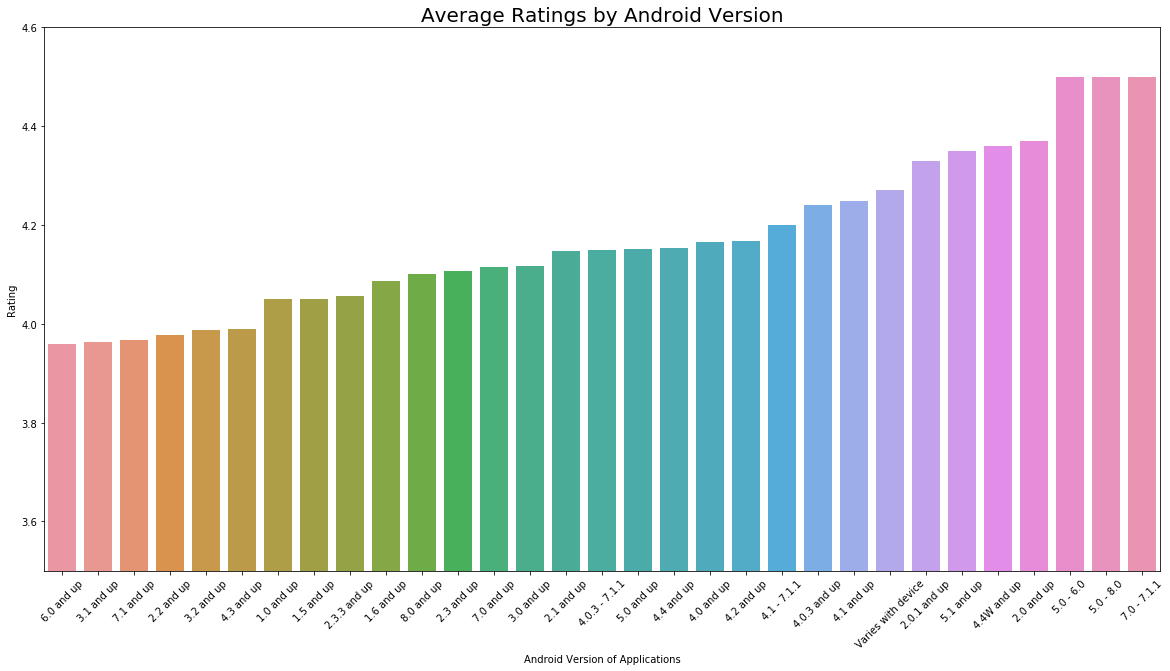

In [53]:
result5 = df.groupby(["Android Ver"])['Rating'].aggregate(np.mean).reset_index().sort_values('Rating')

plt.figure(figsize=(20,10))
sns.barplot(x=df['Android Ver'], y=df.Rating, ci=None, order=result5['Android Ver'])

plt.xticks(rotation = 45)
plt.ylim(3.5,4.6)
plt.xlabel('Android Version of Applications')
plt.ylabel('Rating')
plt.title('Average Ratings by Android Version',size=20)
plt.show()

Based on the barplot, we cannot see the relationship between ratings and current android version of applications.

## Wordcloud for Reviews

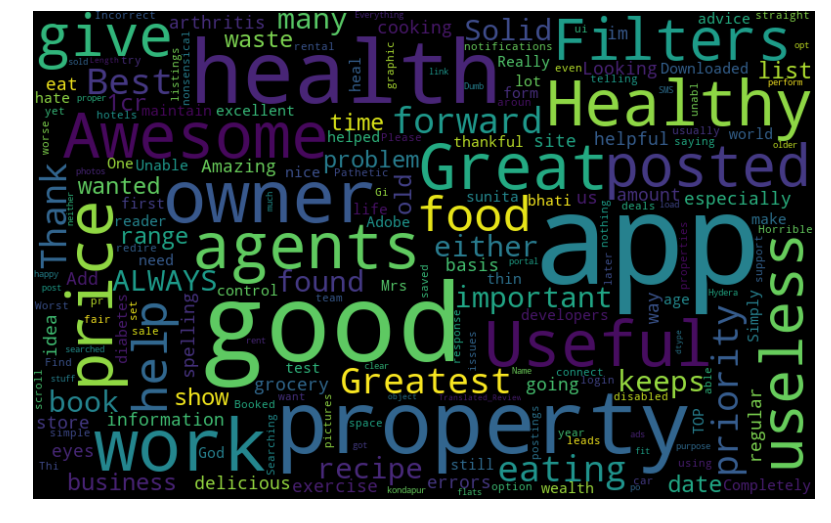

In [54]:
text = str(review['Translated_Review'])
plt.subplots(figsize = (14,11))
wordcloud = WordCloud(stopwords = STOPWORDS, max_font_size = 130,\
                      width = 800, height = 500).generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [55]:
positive_review_df = (review[review.Sentiment == 'Positive'].count().iloc[0] / review['Sentiment'].count() * 100).round()
negative_review_df = (review[review.Sentiment == 'Negative'].count().iloc[0] / review['Sentiment'].count() * 100).round()
neutral_review_df = (review[review.Sentiment == 'Neutral'].count().iloc[0] / review['Sentiment'].count() * 100).round()

positive_review_df, negative_review_df, neutral_review_df

(64.0, 21.0, 15.0)

The percentages of positives, negative and neutral reviews are 64%, 21% and 15% respectively. 

# 3. Model Building

## Cross Validation

We use the K-Fold package to automatically generate the index of validation for linear regression and knn.

In [56]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression,Lasso,Ridge

In [57]:
def kFoldValidation(k, model, X_train, Y_train):
    mseTotal = []
    kf = KFold(n_splits=k, random_state=52, shuffle=True)
    for train_index, test_index in kf.split(X_train):     # Generate the index
        x_train, x_test = X_train[train_index,], X_train[test_index,]
        y_train, y_test = Y_train[train_index,], Y_train[test_index,]
        model.fit(x_train,y_train)
        pred = model.predict(x_test)                      # Use the validation set for prediction
        mse = np.mean((pred - y_test)**2)                 # Calculate the mean squared error
        mseTotal.append(mse)
    return np.array(mseTotal)

Preparing variables for model construction:
Drop column "App" and "Priceband" from previous work.

In [58]:
df1=df.drop(['App','PriceBand','ContentRatingBand'], axis=1)
df1.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Android Ver
0,ART_AND_DESIGN,4.1,159,19.0,8,Free,0.0,Everyone,Art & Design,4.0.3 and up
1,ART_AND_DESIGN,3.9,967,14.0,11,Free,0.0,Everyone,Art & Design;Pretend Play,4.0.3 and up
2,ART_AND_DESIGN,4.7,87510,8.7,13,Free,0.0,Everyone,Art & Design,4.0.3 and up
3,ART_AND_DESIGN,4.5,215644,25.0,15,Free,0.0,Teen,Art & Design,4.2 and up
4,ART_AND_DESIGN,4.3,967,2.8,10,Free,0.0,Everyone,Art & Design;Creativity,4.4 and up


Convert columns "Android Ver","Category","Content Rating","Genres" to dummy variables. 

In [59]:
df1=pd.get_dummies(df1, columns=["Android Ver","Category","Content Rating","Genres"])
df1.head()

,Rating,Reviews,Size,Installs,Type,Price,Android Ver_1.0 and up,Android Ver_1.5 and up,Android Ver_1.6 and up,Android Ver_2.0 and up,...,Genres_Tools,Genres_Tools;Education,Genres_Travel & Local,Genres_Travel & Local;Action & Adventure,Genres_Trivia,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word
0,4.1,159,19.0,8,Free,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.9,967,14.0,11,Free,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.7,87510,8.7,13,Free,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.5,215644,25.0,15,Free,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.3,967,2.8,10,Free,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Converting Type classification into binary

In [60]:
def type_cat(types):
    if types == 'Free':
        return 0
    else:
        return 1

df1['Type'] = df1['Type'].map(type_cat)

## Linear Regression

Start construction of simple linear regression.

In [61]:
import statsmodels.formula.api as sm
import statsmodels.api as sa

In [62]:
X = df1.drop(['Rating',], axis=1)
y = df1["Rating"]
lm1 = sm.OLS(y,X).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     4.515
Date:                Tue, 11 Dec 2018   Prob (F-statistic):           1.23e-68
Time:                        15:41:17   Log-Likelihood:                -6488.3
No. Observations:                8890   AIC:                         1.330e+04
Df Residuals:                    8729   BIC:                         1.444e+04
Df Model:                         160                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Reviews                                       4.919e-09      2e-09      2.464      0.014       1e-09    8.83e-09
Size                                             0.0003      0.000      0.982      0.326      -0.000       0.001
Installs                                         0.0154      0.002      7.424      0.000       0.011       0.019
Type                                             0.1547      0.024      6.421      0.000       0.107       0.202
Price                                           -0.0009      0.000     -2.620      0.009      -0.002      -0.000
Android Ver_1.0 and up                           0.4203      0.351      1.199      0.231      -0.267       1.108
Android Ver_1.5 and up                           0.3974      0.129      3.079      0.002       0.144       0.650
Android Ver_1.6 and up                           0.4703      0.067      7.041      0.000       0.339       0.601
Android Ver_2.0 and up                           0.7379      0.102      7.234      0.000       0.538       0.938
Android Ver_2.0.1 and up                         0.5840      0.191      3.053      0.002       0.209       0.959
Android Ver_2.1 and up                           0.4768      0.060      7.992      0.000       0.360       0.594
Android Ver_2.2 and up                           0.3508      0.051      6.919      0.000       0.251       0.450
Android Ver_2.3 and up                           0.4454      0.043     10.455      0.000       0.362       0.529
Android Ver_2.3.3 and up                         0.4178      0.049      8.594      0.000       0.322       0.513
Android Ver_3.0 and up                           0.4734      0.051      9.369      0.000       0.374       0.572
Android Ver_3.1 and up                           0.3639      0.178      2.042      0.041       0.015       0.713
Android Ver_3.2 and up                           0.3835      0.096      3.995      0.000       0.195       0.572
Android Ver_4.0 and up                           0.5302      0.040     13.300      0.000       0.452       0.608
Android Ver_4.0.3 - 7.1.1                        0.5374      0.351      1.530      0.126      -0.151       1.226
Android Ver_4.0.3 and up                         0.5966      0.040     15.000      0.000       0.519       0.675
Android Ver_4.1 - 7.1.1                          0.5977      0.494      1.210      0.226      -0.371       1.566
Android Ver_4.1 and up                           0.5977      0.039     15.412      0.000       0.522       0.674
Android Ver_4.2 and up                           0.5354      0.046     11.609      0.000       0.445       0.626
Android Ver_4.3 and up                           0.3725      0.051      7.286      0.000       0.272       0.473
Android Ver_4.4 and up          

Now we find the mean squared error of K-fold cross validation for simple linear regression full model.

In [63]:
X1 = np.array(X)
y1 = np.array(y)

In [64]:
ols = LinearRegression()

Get the Mean Square Error of Ordinary Least Square

In [65]:
olsMSE = kFoldValidation(5, ols, X1, y1)
olsMSE

array([0.26844482, 0.25741638, 0.2562959 , 0.27572637, 0.23754209])

In [66]:
np.mean(olsMSE)

0.25908511419491315

Note that R-squared is 0.076 and MSE is as above: 0.26844482, 0.25741638, 0.2562959 , 0.27572637, 0.23754209.

Average MSE across five folds is 0.259 for simple linear regression full model.

We know that converting too many categorical variables will boost up the dimensionality henceforth the variance, therefore we try dropping the dummy variables for now.

In [67]:
X = df.drop(['Android Ver','Content Rating','Category','Genres','App','Rating','PriceBand','ContentRatingBand'],axis=1)
X.head()

,Reviews,Size,Installs,Type,Price
0,159,19.0,8,Free,0.0
1,967,14.0,11,Free,0.0
2,87510,8.7,13,Free,0.0
3,215644,25.0,15,Free,0.0
4,967,2.8,10,Free,0.0


Converting Type classification into binary

In [68]:
def type_cat(types):
    if types == 'Free':
        return 0
    else:
        return 1

Start construction of simple linear regression with reduced regressor matrix.

In [69]:
X['Type'] = X['Type'].map(type_cat)
y = df["Rating"]
lm2 = sm.OLS(y,X).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                 1.955e+04
Date:                Tue, 11 Dec 2018   Prob (F-statistic):               0.00
Time:                        15:41:17   Log-Likelihood:                -14369.
No. Observations:                8890   AIC:                         2.875e+04
Df Residuals:                    8885   BIC:                         2.878e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Reviews    -8.235e-08   4.53e-09    -18.192      0.000   -9.12e-08   -7.35e-08
Size           0.0032      0.001      5.101      0.000       0.002       0.004
Installs       0.3571      0.002    201.571      0.000       0.354       0.361
Type           1.6727      0.051     32.504      0.000       1.572       1.774
Price         -0.0010      0.001     -1.231      0.218      -0.003       0.001
==============================================================================
Omnibus:                      931.937   Durbin-Watson:                   1.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1253.124
Skew:                           0.872   Prob(JB):                    7.72e-273
Kurtosis:                       3.582   Cond. No.                     1.17e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now we find mean squared error for simple linear regression with reduced regressor matrix.

In [70]:
X2 = np.array(X)
y2 = np.array(y)

In [71]:
ols2 = LinearRegression()

In [72]:
olsMSE2 = kFoldValidation(5, ols2, X2, y2)
olsMSE2

array([0.2770635 , 0.263966  , 0.26477249, 0.28150126, 0.24792595])

In [73]:
np.mean(olsMSE2)

0.2670458409520016

Note that R-squared is 0.917 and MSE is as above: 0.27786284, 0.25898129, 0.26741276, 0.25694349, 0.27350739.

Average MSE across five folds is 0.267 for simple linear regression full model.

This is a great improvement compared to ols model with categorical variables, without too much sacrifice of MSE.


## Ridge Regression

First for regressor matrix with categorical variables.

In [74]:
ridge = Ridge(alpha=0.01)
ridgeMSE = kFoldValidation(5, ridge, X1, y1)
ridgeMSE

C:\Users\Fang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.214215e-20
  overwrite_a=True).T
C:\Users\Fang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.693055e-19
  overwrite_a=True).T
C:\Users\Fang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.630722e-19
  overwrite_a=True).T
C:\Users\Fang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guara

array([0.26843527, 0.25740059, 0.25627994, 0.27571018, 0.23753848])

In [75]:
np.mean(ridgeMSE)

0.25907289212380163

Now for regressor matrix without categorical variables.

In [76]:
ridge = Ridge(alpha=0.01)
ridgeMSE2 = kFoldValidation(5, ridge, X2, y2)
ridgeMSE2

array([0.27706348, 0.263966  , 0.26477249, 0.28150125, 0.24792598])

In [77]:
np.mean(ridgeMSE2)

0.26704583967733564

## Lasso

First for regressor matrix with categorical variables.

In [78]:
lasso = Lasso(alpha=0.01)
lassoMSE = kFoldValidation(5, lasso, X1, y1)
lassoMSE

array([0.2775079 , 0.26515067, 0.26618768, 0.28274616, 0.2501353 ])

In [79]:
np.mean(lassoMSE)

0.2683455419413413

Now for regressor matrix without categorical variables.

In [80]:
lasso = Lasso(alpha=0.01)
lassoMSE2 = kFoldValidation(5, lasso, X2, y2)
lassoMSE2

array([0.27771743, 0.26536303, 0.26632399, 0.28279234, 0.25035115])

In [81]:
np.mean(lassoMSE2)

0.2685095883939999

The average of ridge mean squared error across five folds is very similar to ols, as 0.259 and 0.267 for full vs dropping categorical models. The average of lasso mean squared error across five folds is slightly better for regressor matrix with categorical variables, as 0.2683 compared to 0.2685 for regressor matrix without categorical variables. But it's no improvement from ols.

With categorical variables, linear models behave better. But we know that dimensionality is an issue here, too many regressors would boost up the variance and eventually result in poor prediction power of the model. We considered method PCA to reduce dimensionality , nevertheless PCA doesn't work well with categorical variables, it only works well with continuous variables. Hence we move on to non-linear methods. KNN,SVM, Random Forest and XGBoost are explored. Among which Random Forest is known as a great way to address the multi-dimension issue with large datasets. 

# K Nearest Neighbors

Look at the 15 closest neighbors

Find the mean accuracy of knn regression using full model regressor matrix and response variable

Calculate the mean accuracy of the KNN model

Then we draw the graph for MSE against k varying from 1 to 20.

In [82]:
knn = KNeighborsRegressor(n_neighbors=15)
knnMSE = kFoldValidation(5, knn, X1, y1)
knnMSE

array([0.27613041, 0.26272736, 0.2661772 , 0.28221142, 0.2532241 ])

In [83]:
np.mean(knnMSE)

0.2680940982377203

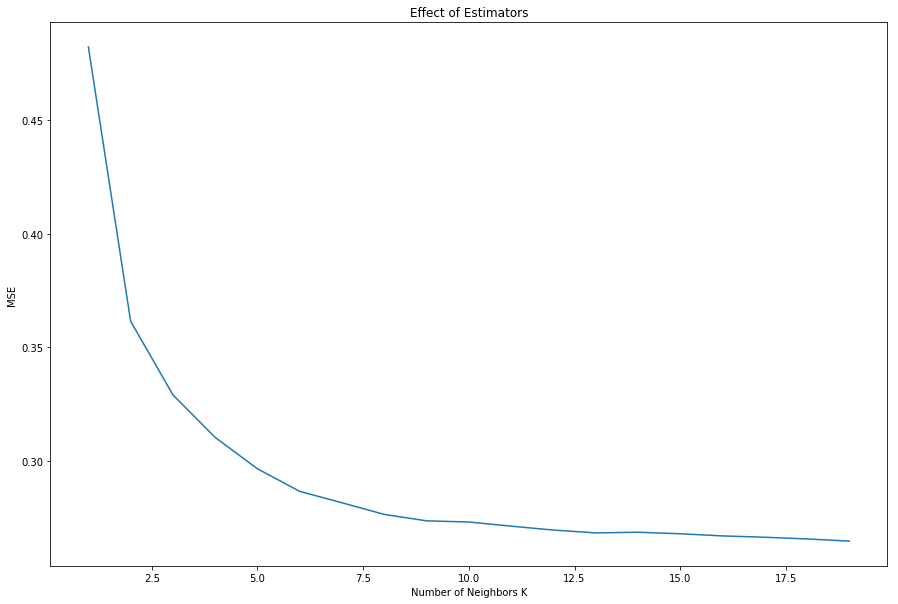

In [84]:
n_neighbors = np.arange(1, 20, 1)
MSE = []
for n in n_neighbors:
    knn.set_params(n_neighbors=n)
    knnMSE1 = kFoldValidation(5, knn, X1, y1)
    avg = np.mean(knnMSE1)
    MSE.append(avg)
plt.figure(figsize=(15, 10))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("MSE")
plt.plot(n_neighbors, MSE)

Repeat the above process for reduced regressor matrix (without categorical variables) and response variable 

In [85]:
knnMSE2 = kFoldValidation(5, knn, X2, y2)
knnMSE2

array([0.27386182, 0.25922861, 0.26026454, 0.28092415, 0.25294321])

In [86]:
np.mean(knnMSE2)

0.2654444659099053

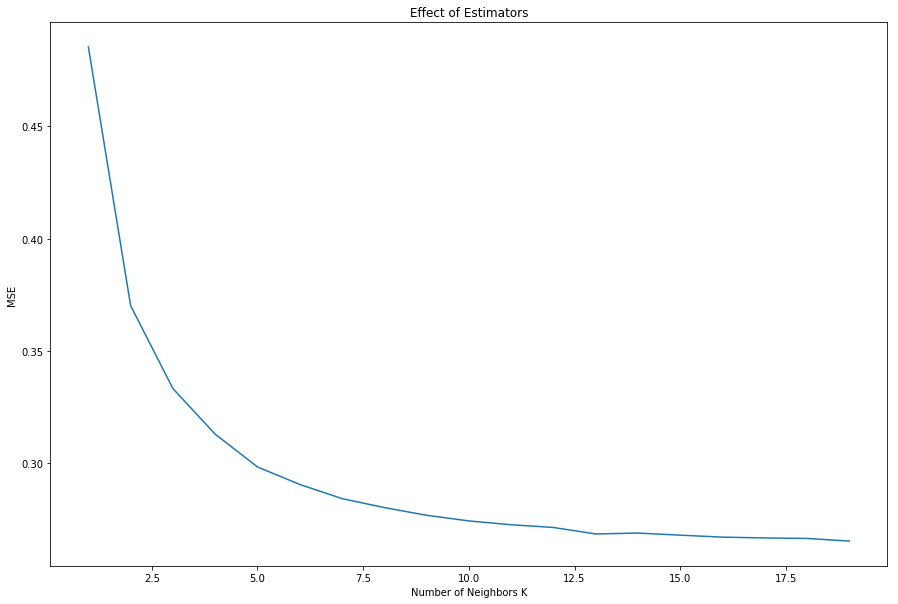

In [87]:
n_neighbors = np.arange(1, 20, 1)
MSE2 = []
for n in n_neighbors:
    knn.set_params(n_neighbors=n)
    knnMSE2 = kFoldValidation(5, knn, X2, y2)
    avg2 = np.mean(knnMSE2)
    MSE2.append(avg2)
plt.figure(figsize=(15, 10))
plt.title("Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("MSE")
plt.plot(n_neighbors, MSE2)

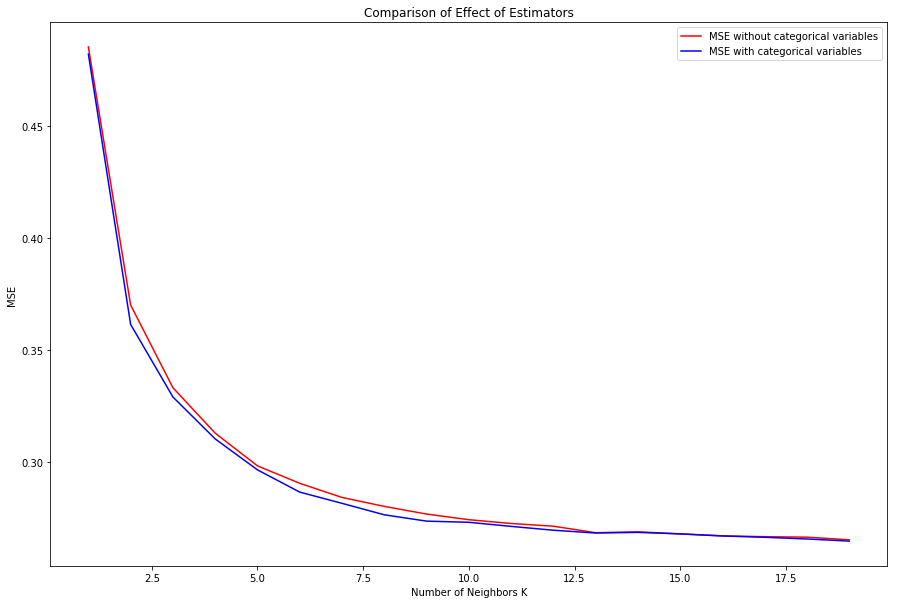

In [88]:
plt.figure(figsize=(15, 10))
plt.plot(n_neighbors, MSE2,'r',label = 'MSE without categorical variables')
plt.plot(n_neighbors, MSE,'b', label = 'MSE with categorical variables')
plt.title("Comparison of Effect of Estimators")
plt.xlabel("Number of Neighbors K")
plt.ylabel("MSE")
plt.legend(loc='upper right')
plt.show()

After comparison, we can see that when k is around 11 to 12, both graphs approach a constant MSE around 0.27. When k is less than 10, clearly the model with categorical variables is doing better with less MSE. When k is above 10, the two graphs merge.    

## Linear SVM

Categorical variables: dummy coding

In [89]:
predictor = df1[list(df1)[1:len(list(df1))]]
response = df1[list(df1)[0]]
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(predictor, response, test_size=0.20)

In [90]:
X_train_d.shape, X_test_d.shape, y_train_d.shape, y_test_d.shape

((7112, 190), (1778, 190), (7112,), (1778,))

In [91]:
model_svm = svm.SVR()
model_svm.fit(X_train_d,y_train_d)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

The difference between the model's prediction and actual rating i.e.: mean prediction error.

In [92]:
result_svm = model_svm.predict(X_test_d)

In [93]:
np.sum(result_svm - y_test_d) / len(y_test_d)

0.0655235587420984

Calculate the mean squared error

In [94]:
np.mean((result_svm - y_test_d) ** 2)

0.26964478554304055

## Random Forest

Set random forest with 50 trees

In [95]:
model_rf1 = RandomForestRegressor(max_depth=20, random_state=42, n_estimators=50)
model_rf1.fit(X_train_d, y_train_d)
result_rf1 = model_rf1.predict(X_test_d)

The difference between the model's prediction and actual rating i.e.: mean prediction error.

In [96]:
np.sum(result_rf1 - y_test_d) / len(y_test_d)

0.019987828678219993

Calculate the mean squared error

In [97]:
np.mean((result_rf1 - y_test_d) ** 2)

0.22478934413271412

Set random forest with 100 trees

In [98]:
model_rf2 = RandomForestRegressor(max_depth=20, random_state=42, n_estimators=100)
model_rf2.fit(X_train_d, y_train_d)
result_rf2 = model_rf2.predict(X_test_d)

The difference between the model's prediction and actual rating i.e.: mean prediction error.

In [99]:
np.sum(result_rf2 - y_test_d) / len(y_test_d)

0.019740163922137708

Calculate the mean squared error

In [100]:
np.mean((result_rf2 - y_test_d) ** 2)

0.224545403741287

It can be observed that random forest with 100 trees produces smaller prediction error and mean square error. 

## Gradient Boosting

In [101]:
model_xgboost = xgb.XGBRegressor(n_estimators=70, learning_rate=0.08, gamma=0, subsample=0.70, colsample_bytree=1, max_depth=7)
model_xgboost.fit(X_train_d, y_train_d)
result_xgboost = model_xgboost.predict(X_test_d)

The difference between the model's prediction and actual rating i.e.: mean prediction error.

In [102]:
np.sum(result_xgboost - y_test_d) / len(y_test_d)

0.005160641402039686

Calculate the mean squared error

In [103]:
np.mean((result_xgboost - y_test_d) ** 2)

0.2242220170027605